In [1]:
import numpy as np
import scipy as sp

from scipy.cluster.hierarchy import to_tree
from skbio.alignment import global_pairwise_align_nucleotide
from skbio import DNA
import skbio
from skbio import Sequence, DNA, TabularMSA, TreeNode, DistanceMatrix
from skbio.alignment import local_pairwise_align_ssw

In [2]:
#генерировала рандомно 1 и 5, а остальные получила просто вставкой символов  

seq1="ACACGGTGAACCTCCGGACTTGAAAGACGTCCCGAAAGTTGTTTACGGTC"
seq2="ACACGGTGAACCTCCGGACTTGAAAGACCATCTTCAACCACTCGCTCAGC"
seq3="ACACGGTGAACCTCCGCATCTTCAACCACTCGCTCAGCTGTTTACGGTC"
seq4="AGAACACACGGTGAACCTCCGGACTTGAAAGACGTCCCGAAAGTTGTTTACGGTC"
seq5="AGAACAAGTTTCCCTCCAGCGGAGACAACATCTTCAACCACTCGCTCAGC"

args = [seq1, seq2, seq3, seq4, seq5]


def kmer_distance(sequence1, sequence2, k=3, overlap=True):
    sequence1_kmers = set(map(str, sequence1.iter_kmers(k, overlap)))
    sequence2_kmers = set(map(str, sequence2.iter_kmers(k, overlap)))
    all_kmers = sequence1_kmers | sequence2_kmers
    shared_kmers = sequence1_kmers & sequence2_kmers
    number_unique = len(all_kmers) - len(shared_kmers)
    fraction_unique = number_unique / len(all_kmers)
    return fraction_unique


args = [DNA(seq1, {"id": "s1"}),DNA(seq2, {"id": "s2"}), DNA(seq3, {"id": "s3"}),DNA(seq4, {"id": "s4"}),DNA(seq5, {"id": "s5"})]

In [3]:
identity_matrix = DistanceMatrix.from_iterable(args, metric=kmer_distance, key='id')

print(identity_matrix)

5x5 distance matrix
IDs:
's1', 's2', 's3', 's4', 's5'
Data:
[[0.         0.5        0.52173913 0.         0.58695652]
 [0.5        0.         0.33333333 0.5        0.325     ]
 [0.52173913 0.33333333 0.         0.52173913 0.43181818]
 [0.         0.5        0.52173913 0.         0.58695652]
 [0.58695652 0.325      0.43181818 0.58695652 0.        ]]


In [4]:
# просто использую загугленный способ из scipy посмотреть, последовательности 2 и 5 вместе, что очень логично! 
# меняла их минимально 
guide_d = sp.cluster.hierarchy.dendrogram(  sp.cluster.hierarchy.average(identity_matrix.condensed_form()), labels=identity_matrix.ids, orientation='right', link_color_func=lambda x: 'black')


In [5]:
#к сожалению, теперь это не дз 5

def upgma(sequences, metric=kmer_distance):
    """ 
    Используется структура skbio.TreeNode.
    Это невзвешенна (UPGMA), не моя,  а готовая сайпаевская((( 

    """
    guide_dm = DistanceMatrix.from_iterable(
                    sequences, metric=metric, key='id')
    guide_lm = sp.cluster.hierarchy.average(guide_dm.condensed_form())
    #guide_tree = to_tree(guide_lm)
    
    guide_tree = TreeNode.from_linkage_matrix(guide_lm, guide_dm.ids)

    return guide_tree

In [6]:
tree = upgma( args )

tree

<TreeNode, name: unnamed, internal node count: 3, tips count: 5>

In [7]:
print(tree)

((s1:0.0,s4:0.0):0.26811594202898553,(s3:0.19128787878787878,(s2:0.1625,s5:0.1625):0.02878787878787878):0.07682806324110675);



In [8]:

def align(args, tree):
 
    seq_lookup = {s.metadata['id']: s for i, s in enumerate(args)}  #это просто информация последовательностей из данных DNA 
     
    c1, c2 = tree.children
    if c1.is_tip():
        c1_aln = seq_lookup[c1.name]
    else:
        c1_aln =  align(args, c1)

    if c2.is_tip():
        c2_aln = seq_lookup[c2.name]
    else:
        c2_aln =  align(args, c2)
        
    alignment, a, b= global_pairwise_align_nucleotide(c1_aln, c2_aln) #a,b не нужны, так как это оценка выравнивания и начало позиций 
 
 #проверка для проходов 
    if isinstance(c1_aln, Sequence):
        alignment[0].metadata = c1_aln.metadata
        len_c1_aln = 1
    else:
        for i in range(len(c1_aln)):
            alignment[i].metadata = c1_aln[i].metadata
        len_c1_aln = len(c1_aln)
    if isinstance(c2_aln, Sequence):
        alignment[1].metadata = c2_aln.metadata
    else:
        for i in range(len(c2_aln)):
            alignment[len_c1_aln + i].metadata = c2_aln[i].metadata
            

    return alignment


In [9]:

result =  align(args, tree)
print(result)

/home/kamilla/anaconda3/lib/python3.7/site-packages/skbio/alignment/_pairwise.py:599: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


TabularMSA[DNA]
-----------------------------------------------------------------------
Stats:
    sequence count: 5
    position count: 122
-----------------------------------------------------------------------
--------------------------------- ... ACTTGAAAGACGTCCCGAAAGTTGTTTACGGTC
--------------------------------- ... ACTTGAAAGACGTCCCGAAAGTTGTTTACGGTC
------------------ACACGGTGAACCTCC ... ---------------------------------
---ACACGGTGAACCTCCGGACT-TGAAAGACC ... ---------------------------------
AGAACAAGTTTC-CCTCCAG-CG--GAGACAAC ... ---------------------------------


Выглядит ужасно. В целом, последовательности сильно различаются.


Ниже пример поближе. 

In [10]:
seq1="ACACGGTGAACCTCCGGACTTGAAAGACGTCCCGAAAGTTGTTTACGGTC"
seq2="ACGGTGAACCTCCGGACTTGAAAGACGTCCCGAAAGTTGTTTACGGTC"
seq3="ACACGGTGAACCTCCGGAAATTGAAAGACGTCCCGAAAGTTGTTTACGGTC"
seq4="ACACGGTGAACCTCCGGACTTGAAAGACGTCCCGCAAGTTGTTTACGGTC"
seq5="ACACGGTGAACCTCCGGACTTGAAAGACGTCCCGAAAGTTGTTTACGGTCCGTC"


args = [DNA(seq1, {"id": "s1"}),DNA(seq2, {"id": "s2"}), DNA(seq3, {"id": "s3"}),DNA(seq4, {"id": "s4"}),DNA(seq5, {"id": "s5"})]
identity_matrix = DistanceMatrix.from_iterable(args, metric=kmer_distance, key='id')
tree = upgma( args )

result = align(args, tree)
print(result)

TabularMSA[DNA]
-------------------------------------------------------
Stats:
    sequence count: 5
    position count: 55
-------------------------------------------------------
ACACGGTGAACCTCCGGAAATTGAAAGACGTCCCGAAAGTTGTTTACGGTC----
ACACGGTGAACCTCCGGAC-TTGAAAGACGTCCCGCAAGTTGTTTACGGTC----
--ACGGTGAACCTCCGGAC-TTGAAAGACGTCCCGAAAGTTGTTTACGGTC----
ACACGGTGAACCTCCGGAC-TTGAAAGACGTCCCGAAAGTTGTTTACGGTC----
ACACGGTGAACCTCCGGAC-TTGAAAGACGTCCCGAAAGTTGTTTACGGTCCGTC


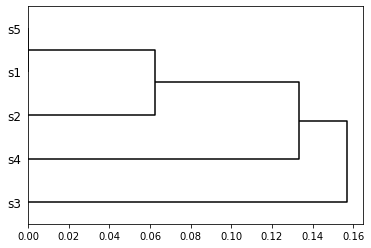

In [11]:
guide_d = sp.cluster.hierarchy.dendrogram(  sp.cluster.hierarchy.average(identity_matrix.condensed_form()), labels=identity_matrix.ids, orientation='right', link_color_func=lambda x: 'black')
